# CAO POINTS ANALYSIS
### AUTHOR: ANTE DUJIC
<hr style="border:2px solid black"> </hr>

## INTRODUCTION
<hr style="border:2px solid gray"> </hr>

This notebook gives an overview of how to load CAO points information from the CAO website into a pandas data frame and the comparison of CAO points in 2019, 2020, and 2021.

[<center><img src="http://www.cao.ie/images/cao.png" width="100"/></center> ](http://www.cao.ie/index.php)

***
### CONTENTS

- [WHAT IS CAO](#CAO)
- [LEVEL 8 - ROUND 1 and ROUND 2](#R1R2)
    - [THE ORIGINAL DATA STRUCTURE]()
    - [SCRAPPING AND CLEANING THE DATA]()
    - [CLEANED DATA]()
- [LEVEL 8 - EOS and MID]()
    - [THE ORIGINAL DATA STRUCTURE]()
    - [SCRAPPING AND CLEANING THE DATA]()
    - [CLEANED DATA]()
2. [CONCATENATING THE DATA](#CONCATENATE)

## WHAT IS CAO? <a id='CAO'></a>
<hr style="border:2px solid gray"> </hr>

The purpose of the Central Applications Office (CAO) is to process centrally applications for undergraduate courses in Irish Higher Education Institutions (HEIs), and to deal with them in an efficient and fair manner. [1]

Students applying for admission to third level education courses in Ireland apply to the CAO rather than to individual educational institutions such as colleges and universities. The CAO then offers places to students who meet the minimum requirements for a course for which they have applied. If for a particular course there are more qualified applicants than available places, the CAO makes offers to those applicants with the highest score in the CAO points system. If students do not accepts offers, or later decline them because they receive an offer for another course, the CAO makes further offers until all of the places have been filled or until the offer season closes. [2]

In [1]:
# HTTP request
import requests as rq

# Regular expressions
import re

# Dates and time
import datetime as dt

# Data frames
import pandas as pd

# For downloading
import urllib.request as urlrq

# PDF
import camelot

# To use .unescape
import html

# Arrays
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

<br>
Current data and time are used for the filenames that will get created to save the original data and the cleaned data. I've used the date and time for easier access and organization of the data, but also to avoid the overwriting of the data files.

In [2]:
# Current date and time
now = dt.datetime.now()
# Format as a string
nowstr = (now.strftime("%Y%m%d_%H%M%S"))

## LEVEL 8 - ROUND 1 and ROUND 2
<hr style="border:2px solid gray"> </hr>

The data for Round 1 and Round 2 for the three given years (2019., 2020., 2021.) has been pulled from the CAO website. As mentioned in the README, CAO practice is to first upload the data with only Round 1 and Round 2 points and then overwrite that data with EOS and MID points after the academic year starts. To obtain the Round 1 and Round 2 data for the 2019. and 2020. I have used [The Internet Archive](https://web.archive.org/). This didn't only allow me access to the archived version of the website but also gave me the same format and the structure of the data for all the years.

### THE ORIGINAL DATA STRUCTURE
***

Original data: <br>
2019: https://web.archive.org/web/20191019135815/http://www2.cao.ie:80/points/l8.php <br>
2020: https://web.archive.org/web/20201108133105/http://www2.cao.ie/points/l8.php <br>
2021: http://www2.cao.ie/points/l8.php

The data for Round 1 and Round 2 points on the CAO website has the following structure:
- Title
- Information on how to read the data
- List of colleges
- Title
- Points
    - Course code
    - Course title
    - Round 1 points
    - Round 2 points

The data of interest is contained under the *Points* section of the website. It is explained below how the data was scrapped, cleaned and saved for the later analysis.

### SCRAPPING AND CLEANING THE DATA
***

<br>
To loop through the years and run multiple lines of code for each year in one go, I've created the dictionary below.

In [3]:
# Defining a dictionary
years_dict = {
    "2019": [("data/cao2019" +  nowstr), "https://web.archive.org/web/20191019135815/http://www2.cao.ie:80/points/l8.php"],
    "2020": [("data/cao2020" +  nowstr), "https://web.archive.org/web/20201108133105/http://www2.cao.ie/points/l8.php"],
    "2021": [("data/cao2021" +  nowstr), "http://www2.cao.ie/points/l8.php"]
}

STEPS:
<br>
1. Save the original html
<br>
This was done to ensure the original website format from which the data was scrapped is kept, in case of any future changes on the CEO website itself. The data was fetched from the given url-s and it was encoded (cp1252), due to symbols in certain course names not being supported. NOTE: Encoding on the website is wrong.
<br>
2. Read the data and filter out only the relevant data
<br>
The fetched data was ittered through and filtered out using the below regular expression. Regular expression is a sequence of characters that specifies a search pattern. Usually such patterns are used by string-searching algorithms for "find" or "find and replace" operations on strings, or for input validation. [4] The set regular expression filters out only the lines starting with the course code (e.g. AL801). Also, Symbol "&" instead "and" was used in certain 2019 and 2020 course names and it was being decoded as "&amp;" when saving to csv. To avoid this *html.unescape* function was used. The data was also structured to fit the csv file - split and divided by commas to create 4 columns "CODE", "TITLE", "R1_POINTS", "R2_POINTS".

In [4]:
# Regular expression
re_course = re.compile(r"([A-Z]{2}[0-9]{3})(.*)")

3. Save the cleaned data as csv files

In [5]:
# Loop through the (dict) years
for year, content in years_dict.items():
    # Fetch the CAO points URL
    rq.get (content[1])
    resp = rq.get (content[1])
    # The server uses the wrong encoding
        # Change to "cp1252"
    resp.encoding = "cp1252"
    # Check if OK:
        #Response [200] means OK
    print (year,resp)
    
    # Save the original html file
    with open(content[0] + ".html", "w") as f:
        f.write(resp.text)
        # Keep track of how many courses we process
    
    no_lines = 0
    # Iterating through the lines
    resp.iter_lines()
    resps = resp.iter_lines()
    
    # Open the csv file for writing (saving)
    with open(content[0] + ".csv", "w") as f:
        # Cleaning the data
        # Write a header row.
        f.write(','.join(["CODE", "TITLE", "R1_POINTS", "R2_POINTS"]) + "\n")
        # Loop through lines of the response.
        for line in resps:
            # Decode the line, using the wrong encoding
            dline = line.decode("cp1252")
            # Converting &amp; to &
            dline = html.unescape(dline)
            # Match only the lines representing courses
            if re_course.fullmatch(dline):
                # Add one to the lines counter
                no_lines = no_lines + 1
                # The course code
                course_code = dline[:5]
                # The course title
                course_title = dline[7:57]
                # Round one points
                course_points = re.split(' +', dline[60:])
                if len(course_points) != 2:
                    course_points = course_points[:2]
                # Join the fields using a comma
                linesplit = [course_code, course_title, course_points[0], course_points[1]]
                # Rejoin the substrings with commas in between
                f.write(",".join(linesplit) + "\n")   
    # Print the total number of processed lines
    print("Total number of lines in CAO", year, "database is", no_lines)

2019 <Response [200]>
Total number of lines in CAO 2019 database is 930
2020 <Response [200]>
Total number of lines in CAO 2020 database is 961
2021 <Response [200]>
Total number of lines in CAO 2021 database is 949


### CLEANED DATA
***

#### 2019
***

In [6]:
# Read csv file
df_2019 = pd.read_csv ("data/cao2019" +  nowstr + ".csv", encoding = "cp1252")
df_2019.columns = ["CODE","TITLE", "R1_2019", "R2_2019"]
# Output random 10 rows
df_2019.sample(n = 10)

,CODE,TITLE,R1_2019,R2_2019
783,LM121,Computer Science (Computer Systems/Games Dev/M...,352,NaN
14,AL842,Bioveterinary Science ...,310,NaN
641,GY262,Commerce (International Hotel Management Shann...,#671,NaN
184,DB514,Business Studies (Law) ...,269,269
576,GA580,Software and Electronic Engineering ...,301,NaN
81,CR305,Physical Sciences (Common Entry) ...,279,NaN
542,DK860,Music ...,#499,#499
593,GA791,Public Health Nutrition ...,364,NaN
239,DC193,Mechatronic Engineering ...,403,NaN
412,TA328,Computing with Language (French/German/Spanish...,262,262


#### 2020
***

In [7]:
# Read csv file
df_2020 = pd.read_csv ("data/cao2020" +  nowstr + ".csv", encoding = "cp1252")
df_2020.columns = ["CODE","TITLE", "R1_2020", "R2_2020"]
# Output random 10 rows
df_2020.sample(n = 10)

,CODE,TITLE,R1_2020,R2_2020
455,TR018,Law and French ...,565,NaN
396,TU914,Business Computing ...,324,NaN
792,LM056,International Business ...,528,NaN
175,AC137,Liberal Arts ...,252,NaN
809,LM100,Physiotherapy ...,589*,NaN
434,TU984,Game Design ...,381,NaN
486,TR072,Pharmacy ...,590,NaN
67,CR108,Mechanical Engineering ...,434,NaN
414,TU951,International Hospitality and Tourism Manageme...,184,184
756,LC297,Community Development ...,235,NaN


#### 2021
***

In [8]:
# Read csv file
df_2021 = pd.read_csv ("data/cao2021" +  nowstr + ".csv", encoding = "cp1252")
df_2021.columns = ["CODE","TITLE", "R1_2021", "R2_2021"]
# Output random 10 rows
df_2021.sample(n = 10)

,CODE,TITLE,R1_2021,R2_2021
841,MH603,Computational Thinking ...,520,NaN
755,LC418,Computing - Games Design and Development ...,260,256
804,LM152,Mental Health Nursing ...,478,466
578,GA680,Mechanical Engineering ...,400,NaN
405,TU941,Botanical Cuisine ...,311,NaN
236,DC161,Analytical Science ...,498,NaN
749,LC380,Automotive Engineering and Transport Managemen...,298,NaN
277,DL825,Applied Psychology ...,418,413
134,CK204,Finance ...,566*,566*
157,CK412,Agricultural Science ...,506,NaN


## 2. LEVEL 8 - EOS and MID
<hr style="border:2px solid gray"> </hr>

As mentioned in README, EOS and MID points data becomes available after the start of the academic year, and are only available for 2019. and 2020. in the time of making this project. However, the project could be updated in the future when the data becomes available for 2021.

### 2019 - THE PDF FILE STRUCTURE
***

Original data: <br>
2019: http://www2.cao.ie/points/lvl8_19.pdf <br>

Data containing EOS and MID points for 2019 is in pdf format.
The file has the following structure:
- Title and the Subtitles of the file
- Information on the file
- Information on how to read the data
- Points table
    - Course code
    - Institution and Course
    - EOS points
    - MID points

The data of interest is contained under the table section of the file. It is explained below how the data was scrapped, cleaned and saved for the later analysis.

### SCRAPPING AND CLEANING THE DATA
***

STEPS:
<br>
1. Save the original file <br>
Same as with the R1 and R2 points, I've saved the original file locally. The data is fetched from the given url using *requests* library.

In [9]:
# Creating a file path for the original data
path_pdf = 'data/cao2019_eos' + nowstr + '.pdf'

In [10]:
# Fetch the CAO points URL
resp_pdf = rq.get("http://www2.cao.ie/points/lvl8_19.pdf")
resp_pdf # <Response [200]> means OK

<Response [200]>

In [11]:
# Save the original file
with open(path_pdf, 'wb') as f:
    f.write(resp_pdf.content)


2. Read the pdf file and filter out the table only 
<br>
The saved data is read using the *camelot* libray.

In [12]:
# Read the pdf file
tables = camelot.read_pdf(path_pdf, pages = "all", flavor = "lattice")


3. Concatenate the tables read 
<br>
Camelot reads the file and returns a table for each page. It is not possible to return one table from all the pages. Therefore, all the tables have to be concatenated.
<br>
4. Save the data as csv file 
<br>
The concatenated table is saved as csv file.

In [13]:
# Check the total number of tables read to decide the loop range
print ("Tables:", tables.n)

Tables: 18


In [14]:
# Create empty list
table_total = []
# Loop through all 18 tables
for x in range (0,18):
    df = tables[x].df
    # Append all 18 tables to table_total
    table_total.append(df)

# Concatenate all tables  
table = pd.concat(table_total)
# Remove old column names
table = table.iloc[1: , :]
# Name the columns
table.columns = ["CODE","TITLE", "EOS_2019", "MID_2019"]
# Sort table by "CODE" column
    # to remove irrelevant data (college names)
table.sort_values("CODE", inplace = True)
# Remove first 35 rows (college names)
table = table.iloc[35: , :]
# Save .csv file
table.to_csv("data/cao2019_eos" +  nowstr + ".csv", index = False)

### CLEANED DATA
***

In [15]:
# Read csv file
df_em_2019 = pd.read_csv ("data/cao2019_eos" +  nowstr + ".csv", encoding = "cp1252")
# Output random 10 rows
df_em_2019.sample(n = 10)

,CODE,TITLE,EOS_2019,MID_2019
569,GY413,Energy Systems Engineering,532,589.0
210,DB500,Computing,242,320.0
311,DK865,Audio and Music Production,301,346.0
293,DC240,"Marketing, Innovation and Technology",451,474.0
674,LY118,Business,287,352.0
40,AS002,"Education, Home Economics and Religious Ed - w...",400*,433.0
181,CW068,Applied Social Studies - Professional Social C...,251,280.0
602,LC289,Precision Engineering,280,369.0
856,TR029,Political Science and Geography,477,500.0
676,LY218,Business - with Spanish/Irish options,298,367.0


### 2020 - THE XLSX FILE STRUCTURE
***

Original data: <br>
2020: http://www2.cao.ie/points/CAOPointsCharts2020.xlsx

Data containing EOS and MID points for 2020 is in xlsx format. It contains the data for LEVEL 6, 7 and 8. The file has the following structure:
The file has the following structure:
- Title and the Subtitles of the file
- Information on the data in the file
- Information on how to read the data
- Points table


The data of interest is contained under the columns *COURSE TITLE, COURSE CODE2, EOS* and *EOS Mid-point*. It is explained below how the data was scrapped, cleaned and saved for the later analysis.

### SCRAPPING AND CLEANING THE DATA
***

STEPS:
<br>
1. Save the original file <br>
To fetch the data from the pdf file I've used the *urllib.request* library. It is fetched from the given url and saved locally.

In [16]:
# Create a file path for the original data
path_xlsx = ("data/cao2020_eos" +  nowstr + ".xlsx")

# Copying network xlsx file
urlrq.urlretrieve('http://www2.cao.ie/points/CAOPointsCharts2020.xlsx', path_xlsx)

('data/cao2020_eos20211211_220306.xlsx',
 <http.client.HTTPMessage at 0x24f238cf7f0>)

2. Read the xlsx file and clear the data <br>
File contains irrelevant data in the first 10 rows, which I've ignored when reading the file. I've then filtered out the relevant data from the table.

In [17]:
# Download and parse the excel spreadsheet
df2020_eos = pd.read_excel("http://www2.cao.ie/points/CAOPointsCharts2020.xlsx", skiprows = 10)

# Filter out only level 8 courses
df2020_eos = df2020_eos.loc[df2020_eos["LEVEL"] == 8]
# Filter out only relevant columns
df2020_eos = df2020_eos [["COURSE CODE2", "COURSE TITLE", "EOS", "EOS Mid-point"]]
# Change column names
df2020_eos.columns = ["CODE","TITLE", "EOS_2020", "MID_2020"]


3. Save the data as csv file

In [18]:
# Save pandas data frame
df2020_eos.to_csv("data/cao2020_eos" +  nowstr + ".csv", index = False)

### CLEANED DATA
***

In [19]:
# Read csv file
df_em_2020 = pd.read_csv ("data/cao2020_eos" +  nowstr + ".csv")
# Output random 10 rows
df_em_2020.sample(n = 10)

,CODE,TITLE,EOS_2020,MID_2020
922,TU875,Pharmaceutical Healthcare,400,440
943,TU914,Business Computing,324,366
745,TL873,Coaching and Sports Performance,289,329
634,MH106,Psychology - 3 years,521,529
113,CK791,Medicine - Graduate Entry (GAMSAT required),57,58
710,SG249,Writing and Literature,297,368
288,DK821,Computing in Software Development,302,361
240,DC118,Gnó agus Gaeilge / Business and Irish,359,429
684,NC010,Psychology,400,440
10,AD217,Illustration (portfolio),#+matric,#+matric


## 3. CONCATENATING THE DATA <a id='CONCATENATE'></a>
<hr style="border:2px solid gray"> </hr>

After cleaning and saving all the data, I've merged them all into one table.

STEPS:
1. Concatenating all the dataframes into one table <br>
This results with a table containing ALL the data from the listed dataframes, meaning the same courses from each table get repeated. 

In [20]:
# Defining a list containing all the saved csv files
df_list = [df_2019, df_em_2019, df_2020, df_em_2020, df_2021]
# Concatenating the data contained within a list
allcourses = pd.concat(df_list)

2. Cleaning the concatenated table <br>
I've filtered out only the common columns, *CODE* and *TITLE*, to create a table containing all the possible courses from each year. This table will be a base on which I will later add the relevant data. I've also removed all the duplicates, sort the values by the *CODE* column and set the same column as the index.


In [21]:
# Filering out columns
allcourses = allcourses [["CODE", "TITLE"]]
# Remove duplicates created concatenating
allcourses.drop_duplicates(subset=["CODE"], inplace=True, ignore_index=False)
# Sort the table by "CODE" column
allcourses.sort_values("CODE", inplace = True)
# set "CODE" column as index 
allcourses.set_index("CODE", inplace=True)
# Print only first 10 rows for an overview
allcourses.head(10)

,TITLE
CODE,
AC120,International Business ...
AC137,Liberal Arts ...
AD101,First Year Art & Design (Common Entry) ...
AD102,Graphic Design and Moving Image Design ...
AD103,Textile & Surface Design and Jewellery & Objec...
AD202,Education & Design or Fine Art (Second Level T...
AD204,Fine Art ...
AD211,Fashion Design ...
AD212,Product Design ...


3. Joining the relevant columns to the "base" table

In [22]:
# Loop - set "CODE" column as index for all df
for i in df_list:
    i.set_index("CODE", inplace=True)
# Joining
allcourses = allcourses.join(df_2019[["R1_2019", "R2_2019"]])
allcourses = allcourses.join(df_em_2019[["EOS_2019", "MID_2019"]])
allcourses = allcourses.join(df_2020[["R1_2020", "R2_2020"]])
allcourses = allcourses.join(df_em_2020[["EOS_2020", "MID_2020"]])
allcourses = allcourses.join(df_2021[["R1_2021", "R2_2021"]])
# Print only first 10
allcourses.head(10)

,TITLE,R1_2019,R2_2019,EOS_2019,MID_2019,R1_2020,R2_2020,EOS_2020,MID_2020,R1_2021,R2_2021
CODE,,,,,,,,,,,
AC120,International Business ...,234,234,234,269.0,209,NaN,209,280,294,294
AC137,Liberal Arts ...,275,252,252,275.0,252,NaN,252,270,271,270
AD101,First Year Art & Design (Common Entry) ...,#+Matric,NaN,# +matric 550,NaN,#+matric,NaN,#+matric,#+matric,#554,NaN
AD102,Graphic Design and Moving Image Design ...,#+Matric,NaN,# +matric 635,NaN,#+matric,NaN,#+matric,#+matric,#538,NaN
AD103,Textile & Surface Design and Jewellery & Objec...,#+Matric,NaN,# +matric 545,NaN,#+matric,NaN,#+matric,#+matric,#505,NaN
AD202,Education & Design or Fine Art (Second Level T...,#+Matric,NaN,# +matric 580,NaN,#+matric,NaN,#+matric,#+matric,#591,NaN
AD204,Fine Art ...,#+Matric,NaN,# +matric 600,NaN,#+matric,NaN,#+matric,#+matric,#514,NaN
AD211,Fashion Design ...,#+Matric,NaN,# +matric 600,NaN,#+matric,NaN,#+matric,#+matric,#760,#679
AD212,Product Design ...,#+Matric,NaN,# +matric 600,NaN,#+matric,NaN,#+matric,#+matric,#413,NaN


4. Saving the final table as a csv file

In [23]:
allcourses.to_csv ("data/Final_table.csv")

## 4. DATA ANALYSIS
<hr style="border:2px solid gray"> </hr>

I've decided to do the analysis and comparison between the mentioned years on the following variables:

1. ROUND 1 POINTS - the required points to enter the given course in the first round
2. ROUND 2 POINTS - the required points to enter the given course in the second round
3. EOS POINTS - the final cut-off points, in other word, the points score achieved by the last applicant being offered a place on that course [3]
4. MID POINTS - the points score of the applicant midwaybetween the highest and the lowest applicant being offered a place [3]

Majority of the courses have only the numeric value, representing the points. Certain courses could also have descriptive symbols, along the numeric value or without it. The mentioned symbols are:

|||
| :-: | :- |
| * | Not all on this points score were offered places |
| # | Test / Interview / Portfolio / Audition |
| AQA | All qualified applicants |
| v | New competition for available places |

In [24]:
# Read in the data for analysis
df = pd.read_csv ("data/Final_table.csv", index_col = ["CODE", "TITLE"])
#df = pd.read_csv ("data/Final_table.csv")
df.head(10)

,,R1_2019,R2_2019,EOS_2019,MID_2019,R1_2020,R2_2020,EOS_2020,MID_2020,R1_2021,R2_2021
CODE,TITLE,,,,,,,,,,
AC120,International Business,234,234,234,269.0,209,NaN,209,280,294,294
AC137,Liberal Arts,275,252,252,275.0,252,NaN,252,270,271,270
AD101,First Year Art & Design (Common Entry),#+Matric,NaN,# +matric 550,NaN,#+matric,NaN,#+matric,#+matric,#554,NaN
AD102,Graphic Design and Moving Image Design,#+Matric,NaN,# +matric 635,NaN,#+matric,NaN,#+matric,#+matric,#538,NaN
AD103,Textile & Surface Design and Jewellery & Objects,#+Matric,NaN,# +matric 545,NaN,#+matric,NaN,#+matric,#+matric,#505,NaN
AD202,Education & Design or Fine Art (Second Level Teach,#+Matric,NaN,# +matric 580,NaN,#+matric,NaN,#+matric,#+matric,#591,NaN
AD204,Fine Art,#+Matric,NaN,# +matric 600,NaN,#+matric,NaN,#+matric,#+matric,#514,NaN
AD211,Fashion Design,#+Matric,NaN,# +matric 600,NaN,#+matric,NaN,#+matric,#+matric,#760,#679
AD212,Product Design,#+Matric,NaN,# +matric 600,NaN,#+matric,NaN,#+matric,#+matric,#413,NaN


To make sure all the data is correctly captured when plotting I changed the type of the columns, to be *float64*. All the columns containing symbols mentioned above are of type *object* so I've decided to replace all symbols with *None*. 

In [25]:
#Check current types
df.dtypes

R1_2019      object
R2_2019      object
EOS_2019     object
MID_2019    float64
R1_2020      object
R2_2020      object
EOS_2020     object
MID_2020     object
R1_2021      object
R2_2021      object
dtype: object

In [26]:
# Filtering out the non numeric values in df
    # Replace all strings with "none"
df_numeric = df.replace(r'\D', "", regex=True)
    # Change columns type from object to numeric
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
df_numeric.head(10)

,,R1_2019,R2_2019,EOS_2019,MID_2019,R1_2020,R2_2020,EOS_2020,MID_2020,R1_2021,R2_2021
CODE,TITLE,,,,,,,,,,
AC120,International Business,234.0,234.0,234.0,269.0,209.0,NaN,209.0,280.0,294.0,294.0
AC137,Liberal Arts,275.0,252.0,252.0,275.0,252.0,NaN,252.0,270.0,271.0,270.0
AD101,First Year Art & Design (Common Entry),NaN,NaN,550.0,NaN,NaN,NaN,NaN,NaN,554.0,NaN
AD102,Graphic Design and Moving Image Design,NaN,NaN,635.0,NaN,NaN,NaN,NaN,NaN,538.0,NaN
AD103,Textile & Surface Design and Jewellery & Objects,NaN,NaN,545.0,NaN,NaN,NaN,NaN,NaN,505.0,NaN
AD202,Education & Design or Fine Art (Second Level Teach,NaN,NaN,580.0,NaN,NaN,NaN,NaN,NaN,591.0,NaN
AD204,Fine Art,NaN,NaN,600.0,NaN,NaN,NaN,NaN,NaN,514.0,NaN
AD211,Fashion Design,NaN,NaN,600.0,NaN,NaN,NaN,NaN,NaN,760.0,679.0
AD212,Product Design,NaN,NaN,600.0,NaN,NaN,NaN,NaN,NaN,413.0,NaN


In [27]:
# Saving numeric only table as csv
df_numeric.to_csv ("Numeric_table.csv")

In [28]:
# Making sure types are correct now
df_numeric.dtypes

R1_2019     float64
R2_2019     float64
EOS_2019    float64
MID_2019    float64
R1_2020     float64
R2_2020     float64
EOS_2020    float64
MID_2020    float64
R1_2021     float64
R2_2021     float64
dtype: object

In [29]:
# Defining variables for the analysis
    # 2019
r1_2019 = df_numeric ["R1_2019"]
r2_2019 = df_numeric ["R2_2019"]
eos_2019 = df_numeric ["EOS_2019"]
mid_2019 = df_numeric ["MID_2019"]
    # 2020
r1_2020 = df_numeric ["R1_2020"]
r2_2020 = df_numeric ["R2_2020"]
eos_2020 = df_numeric ["EOS_2020"]
mid_2020 = df_numeric ["MID_2020"]
    # 2021
r1_2021 = df_numeric ["R1_2021"]
r2_2021 = df_numeric ["R2_2021"]

## COMPARISON
***

1. Total number of courses for each year - bar plot
     - Total number of courses with symbols
     - Total number of courses had R2
2. Avarages of R1, R2, EOS, MID - bar plot   
3. Points spreed (by hundred) - histogram + scatterplot
    - R1, R2,  vs R1, R2
    - R1, R2, EOS, MID vs R1, R2, EOS, MID
4. Describe - boxplot
    

In [70]:
#print ("There are", df["CODE"].count(), "courses in total in years 2019, 2020 and 2021.")
#print ("Of them:\n- There were", df_2019["CODE"].count())

In [37]:
df_2019["R1_2019"].count()

916

In [38]:
r1_df = df ["EOS_2019"]
r1_df.count()

926

In [39]:
r1_2019.count()

890

In [40]:
desc = df_numeric.describe()
desc

,R1_2019,R2_2019,EOS_2019,MID_2019,R1_2020,R2_2020,EOS_2020,MID_2020,R1_2021,R2_2021
count,890.000000,197.000000,915.000000,906.000000,927.000000,206.000000,993.000000,988.000000,923.000000,255.000000
mean,380.137079,380.060914,377.156284,424.698675,390.743258,392.160194,391.799597,448.198381,407.666306,414.749020
std,121.704187,132.624783,125.310322,132.632707,128.482188,129.948652,128.446837,129.237735,128.706224,141.693386
min,59.000000,146.000000,55.000000,57.000000,55.000000,184.000000,55.000000,57.000000,57.000000,60.000000
25%,297.250000,269.000000,290.000000,339.000000,300.000000,281.000000,300.000000,362.000000,303.000000,293.500000
50%,352.000000,381.000000,349.000000,392.000000,366.000000,400.500000,368.000000,426.500000,391.000000,424.000000
75%,442.750000,474.000000,441.000000,476.000000,465.500000,498.750000,474.000000,510.000000,499.000000,521.500000
max,972.000000,939.000000,979.000000,1073.000000,1088.000000,768.000000,1088.000000,1088.000000,1028.000000,904.000000


In [61]:
counts = df_numeric.reset_index(drop=True)
counts

,R1_2019,R2_2019,EOS_2019,MID_2019,R1_2020,R2_2020,EOS_2020,MID_2020,R1_2021,R2_2021
0,234.0,234.0,234.0,269.0,209.0,NaN,209.0,280.0,294.0,294.0
1,275.0,252.0,252.0,275.0,252.0,NaN,252.0,270.0,271.0,270.0
2,NaN,NaN,550.0,NaN,NaN,NaN,NaN,NaN,554.0,NaN
3,NaN,NaN,635.0,NaN,NaN,NaN,NaN,NaN,538.0,NaN
4,NaN,NaN,545.0,NaN,NaN,NaN,NaN,NaN,505.0,NaN
...,...,...,...,...,...,...,...,...,...,...
1209,275.0,NaN,275.0,322.0,271.0,NaN,271.0,318.0,270.0,NaN
1210,274.0,NaN,274.0,311.0,270.0,NaN,270.0,349.0,262.0,NaN
1211,273.0,NaN,273.0,348.0,253.0,NaN,253.0,369.0,230.0,230.0
1212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266.0,NaN


In [76]:
plt.rcParams["figure.figsize"] = (25, 5)

<AxesSubplot:>

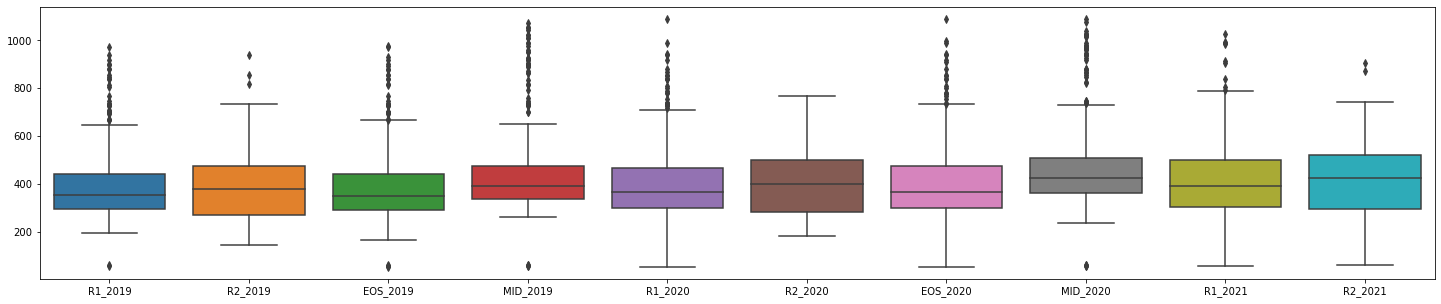

In [77]:
sns.boxplot (data = counts)

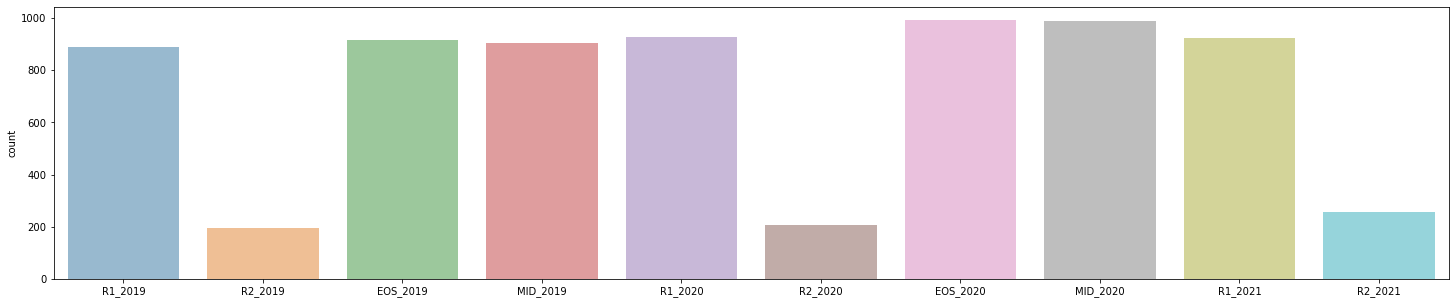

In [78]:
#plt.xticks (ticks = (100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100))
sns.countplot (data = counts, alpha = 0.5)
#plt.legend(["r1_2019", "r1_2020", "r1_2021", "r2_2019", "r2_2020", "r2_2021"])
plt.show()

In [79]:
rounds = [r1_2019, r2_2019, r1_2020, r2_2020, r1_2021, r2_2021]

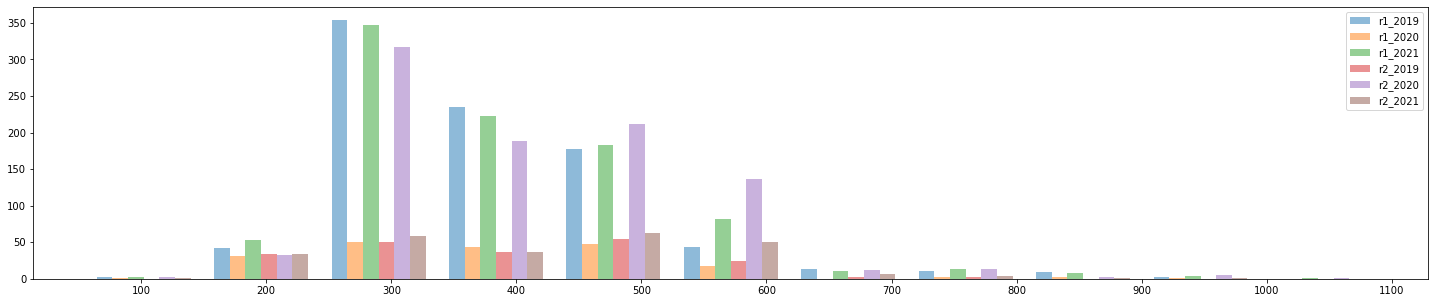

In [80]:
plt.xticks (ticks = (100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100))
plt.hist (rounds, alpha = 0.5, bins = 11)
plt.legend(["r1_2019", "r1_2020", "r1_2021", "r2_2019", "r2_2020", "r2_2021", "eos_2019", "eos_2020", "mid_2019", "mid_2019"])
plt.show()

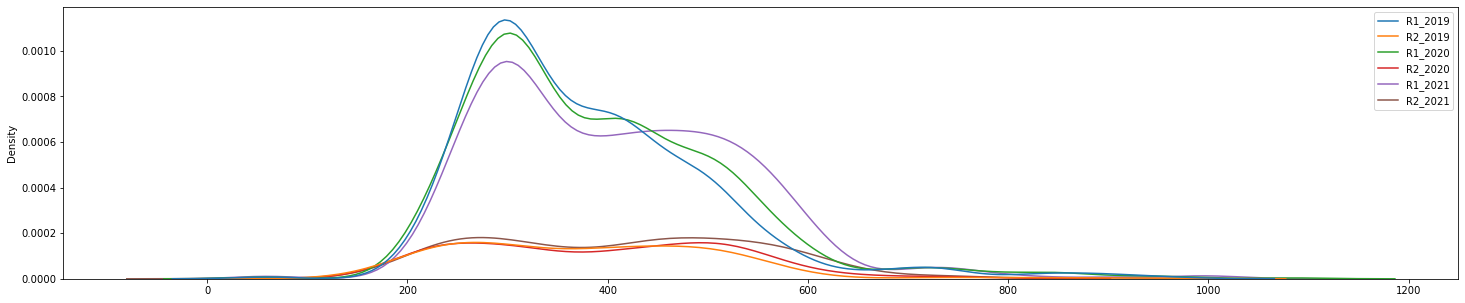

In [81]:
sns.kdeplot (data = rounds)
plt.show()

In [82]:
eos_mid = [eos_2019, mid_2019, eos_2020, mid_2020]

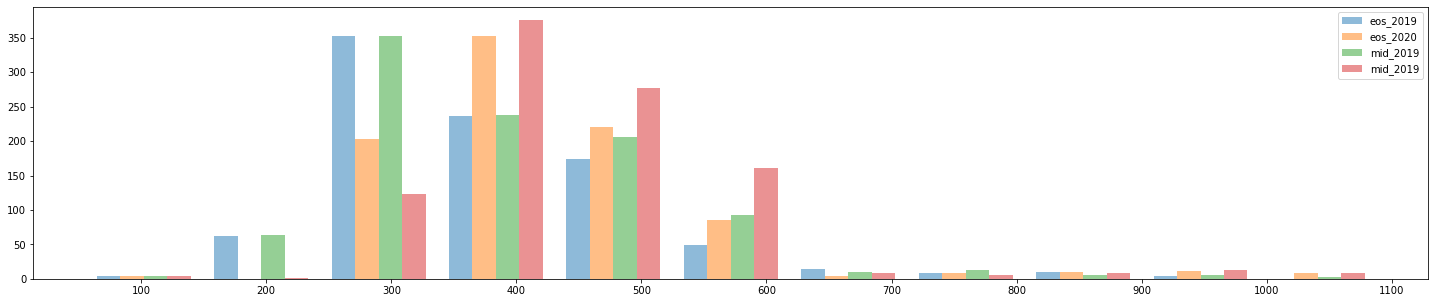

In [83]:
plt.xticks (ticks = (100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100))
plt.hist (eos_mid, alpha = 0.5, bins = 11)
plt.legend(["eos_2019", "eos_2020", "mid_2019", "mid_2019"])
plt.show()

# CONCLUSION

***

## REFERENCES
***

- [1] http://www2.cao.ie/handbook/handbook2022/hb.pdf
- [2] https://en.wikipedia.org/wiki/Central_Applications_Office7
- [3] https://www.independent.ie/life/family/learning/understanding-your-cao-course-guide-26505318.html
- [4] https://en.wikipedia.org/wiki/Regular_expression

## TESTING

In [84]:
df2020_num_r1 = df ["R1_2020"]

In [85]:
df2020_num_r1.count()

944

In [86]:
a = df2020_num_r1[df2020_num_r1.str.contains("\#", na = False)]
a.count()

87

In [87]:
b.count()

NameError: name 'b' is not defined

|||
| :-: | :- |
| * | Not all on this points score were offered places |
| # | Test / Interview / Portfolio / Audition |
| AQA | All qualified applicants |
| v | New competition for available places |